In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Yelp Reviews and Restaurants

## **Motivation**
We are working with two datasets from Yelp. One containing a subset of businesses in USA and Canada and one containing reviews of these businesses. We chose this dataset as we thought it would be fun and interesting to analyse review trends both time-wise and geographically. Furthermore, the datasets is larget enough and contain enough information to hopefully gain alot of fun insights. As the dataset contains only a subset of the cities on yelp we chose to work specifically on the Philidelphia part of the dataset as this was the largest city present.

In the end, we want to inform the reader not only about interesting review trends worth taking into account but also showcase specific areas' ratings to guide them in where to go next for good experience.


## **Basic Stats**
In this section we cover the two datasets and out choices in data preparation and preprocessing as well as some basic stats of the data.

### *Data: Businesses*
The full business dataset contains ~150.000 businesses and for each of these it has:
- Name
- Business ID
- Location 
- Average rating from 1-5
- Number of reviews
- Categories (Hotel, Restaurant, etc.)
- Various attributes (Such as parking or payment options)
- Opening hours

Firstly we want to filter the business data to contain only those in Philadelphia:

In [7]:
# Load and filter the business dataset
df_business = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)
df_business = df_business[df_business['city'] == 'Philadelphia']
print(f"Number of businesses in Philadelphia: {len(df_business)}")
print("Sample data from the business dataset:")
# Display the first row of the filtered dataset
df_business.head(1)

Number of businesses in Philadelphia: 14569
Sample data from the business dataset:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


We then want to find those that are labeled as restaurants:

In [8]:
restaurant_ids = set()
for _, b in df_business.iterrows():
    if b['categories'] and 'Restaurants' in b['categories']:
        restaurant_ids.add(b['business_id'])
print(f"Number of restaurants in Philadelphia: {len(restaurant_ids)}")


Number of restaurants in Philadelphia: 5852


We see that we have data on 5852 restaurants in Philadelphia.

### *Data: Reviews*
The full review dataset contains ~7.000.000 reviews and for each of these it has:
- Review ID
- User ID
- Business ID
- Rating
- Other users' opinion of the review
- Textual review
- Date and time of day

Firstly, we want to look solely on the reviews for restaurants which we have data on:

In [9]:
df_reviews = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)
# Filter reviews to include only those for restaurants in Philadelphia
df_reviews = df_reviews[df_reviews['business_id'].isin(restaurant_ids)]
print(f"Number of reviews for restaurants in Philadelphia: {len(df_reviews)}")
print("Sample data from the reviews dataset:")
# Display the first row of the filtered dataset
df_reviews.head(1)

Number of reviews for restaurants in Philadelphia: 687289
Sample data from the reviews dataset:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03


We see that we have just under 700.000 reviews of restaurants in Philadelphia

## **Data Analysis**



## *Time Analysis*
In this part of the analysis, we look at restaurant reviews from Philadelphia to find out how time of day affects reviews.

We want to answer a few questions:

- When during the day do people leave the most reviews?

- Does the time of review change how good or bad the review is?

- Do some businesses get different kinds of reviews depending on the time? 

To find out, we made different plots to show the trends and patterns in the data.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Knowing that the JSON file is structured with each line as a separate JSON object
philly_reviews_df = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)

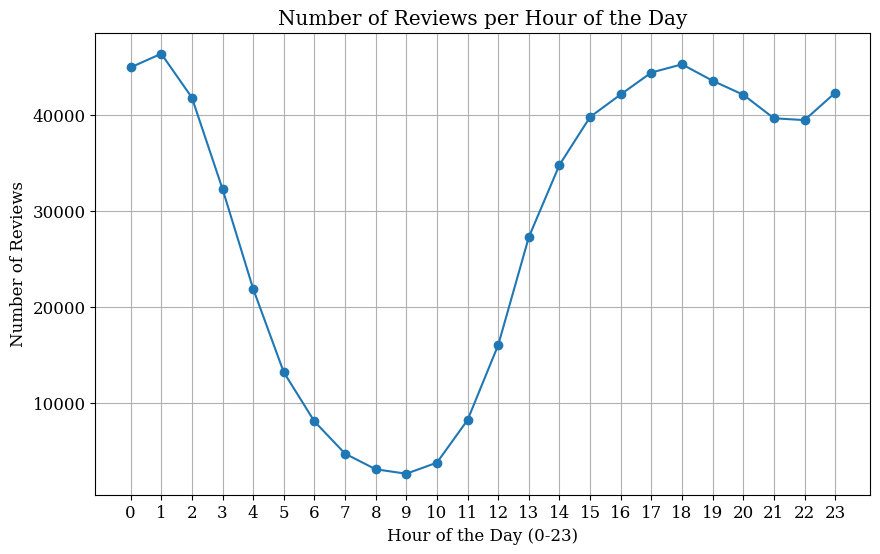

In [11]:
# Extract the hour from the 'date' column
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Group by hour and count the number of reviews for each hour
reviews_per_hour = philly_reviews_df.groupby('hour').size()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12       
   
plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title('Number of Reviews per Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

To begin, we created a line chart that shows how the number of reviews changes depending on the hour of the day.
From the plot, it's clear that most reviews are written between 4 PM and 2 AM. This makes sense, since restaurants are usually busiest during dinnertime and late at night, when more people are out eating or grabbing late-night food and more customers often means more reviews.

### *Interactive chart of ratings depending on the time of day*
Secondly, we wanted to explore whether the star ratings people give change depending on the time of day.
To investigate this, we created an interactive Bokeh chart that allows users to toggle between different 3-hour time blocks and see how the distribution of star ratings changes throughout the day.

In [12]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

# Enable Bokeh in the notebook
output_notebook()

import pandas as pd
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, FactorRange

output_notebook()

HighContrast10 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf"   # Teal  
]

# Prepare data
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Create 3-hour time blocks
def map_three_hour_block(hour):
    start = (hour // 3) * 3
    end = start + 2
    return f"{start:02d}-{end:02d}"

philly_reviews_df['three_hour_block'] = philly_reviews_df['hour'].apply(map_three_hour_block)

# Count reviews per (star, time block)
grouped = philly_reviews_df.groupby(['stars', 'three_hour_block']).size().unstack(fill_value=0)

# Make sure columns are sorted by time
time_blocks = sorted(grouped.columns)
grouped = grouped[time_blocks]

for star in range(1, 6):
    if star not in grouped.index:
        grouped.loc[star] = [0] * len(time_blocks)

grouped = grouped.sort_index()
grouped.index = grouped.index.map(str)
stars = grouped.index.tolist()

grouped.reset_index(inplace=True)
grouped.rename(columns={'stars': 'stars'}, inplace=True)
source = ColumnDataSource(grouped)

p = figure(x_range=FactorRange(*stars),
           height=500, width=900,
           title="Review Counts per Star Rating across 3-Hour Blocks",
           toolbar_location="above", tools="pan,wheel_zoom,reset,save")

colors = HighContrast10

for i, block in enumerate(time_blocks):
    p.vbar(x='stars',
           top=block,
           source=source,
           width=0.2,
           color=colors[i % len(colors)],
           legend_label=block,
           muted_alpha=0.1,
           muted=True,
           alpha=0.7)

p.xaxis.axis_label = "Star Rating"
p.yaxis.axis_label = "Number of Reviews"
p.xaxis.major_label_orientation = 1.0
p.x_range.range_padding = 0
p.y_range.start = 0
p.title.text_font_size = "14pt"
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.add_layout(p.legend[0], 'left')

show(p)



Loading BokehJS ...

Loading BokehJS ...

From this chart, users can easily toggle between different time slots to see how star ratings are distributed throughout the day.
However, the overall pattern looks very similar across all time blocks:

- 1-star reviews are more common than 2-star reviews
- 5 stars is the most frequently given rating in all time slots
- 4-star reviews are more common than 3 stars, but less common than 5 stars
- 3-star reviews appear more often than both 1- and 2-star reviews

### *Time analysis of three specific businesses*
For the next step, we wanted to dig deeper into individual businesses to see how star ratings vary throughout the day.
To find businesses worth studying, we first filtered for businesses with at least 50 reviews to ensure the data was reliable.
Then, we calculated the standard deviation of star ratings for each business and selected those with the highest variation.
Businesses with a wide range of different reviews are especially interesting to investigate, as they might show stronger time-based trends. As an example, this can be used for Yelp users to determine at what time they should go to the restaurant.

['97SR7RQPL02t5J41UcZ4SQ', 'jPG_BuIKf0KBCFY6u00h-A', 'fT0lXvUz41XaZbgtSMqTKg']
Top 3 businesses with highest variation and their review counts:
- Pat's Pizzeria: 51 reviews
- Love Park Pizza and Chicken: 55 reviews
- Mangiamo 444: 55 reviews


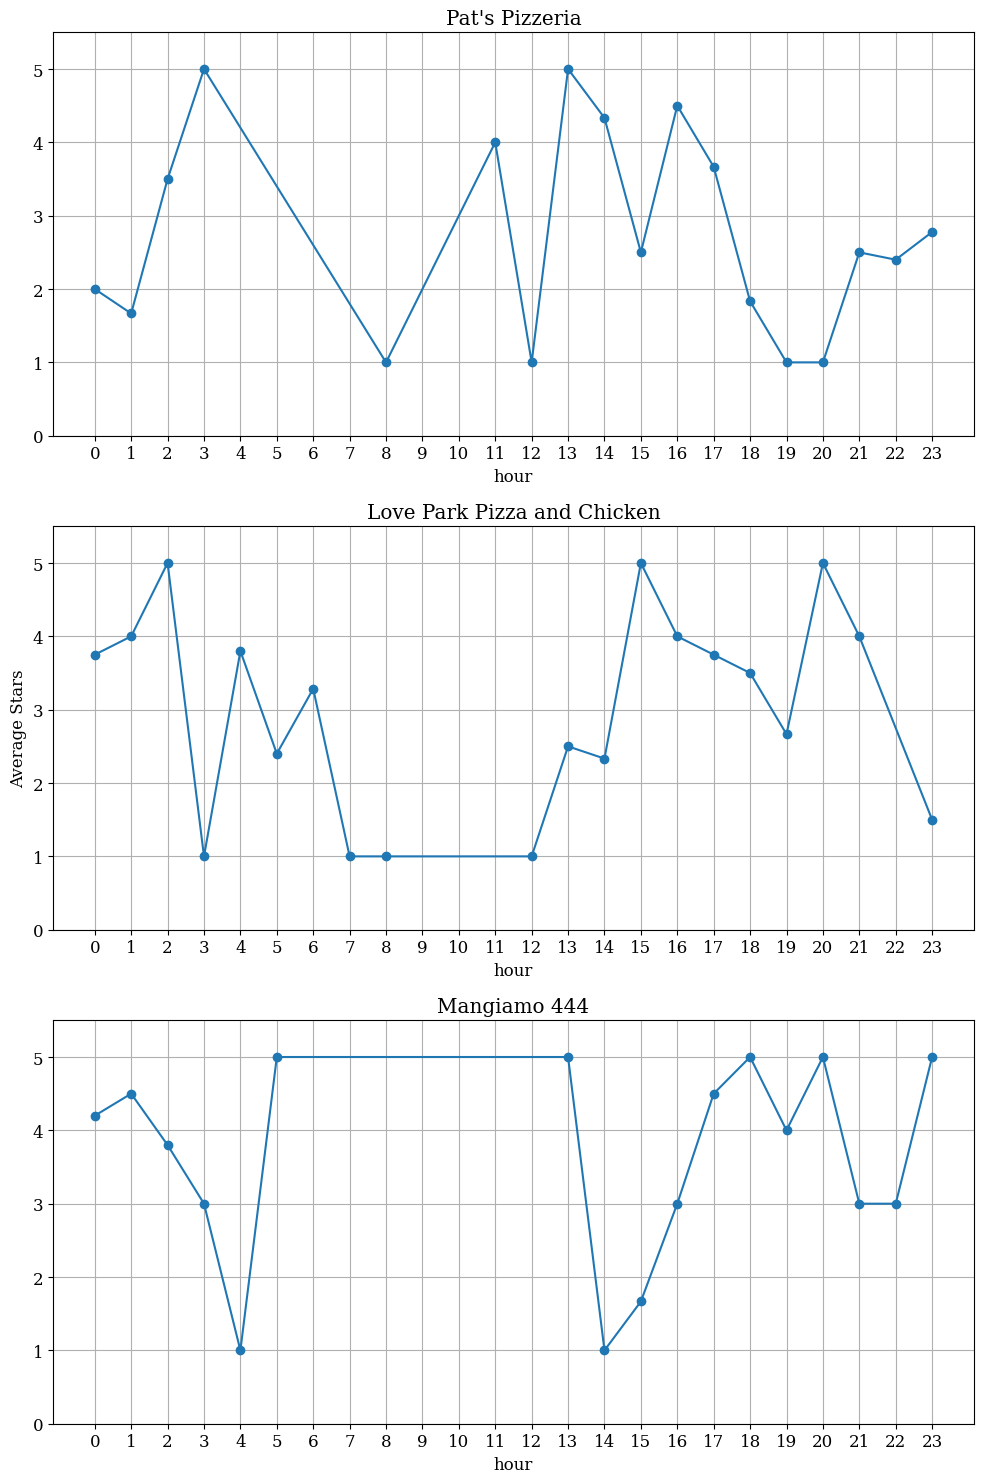

In [14]:
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)

# Count number of reviews per business
review_counts = philly_reviews_df.groupby('business_id').size()

# Keep only businesses with at least 50 reviews
businesses_with_enough_reviews = review_counts[review_counts >= 50].index.tolist()

# Group reviews by business and hour, and calculate mean stars
business_hour_avg = philly_reviews_df.groupby(['business_id', 'hour'])['stars'].mean().reset_index()

# Calculate std for each business
business_variability = business_hour_avg.groupby('business_id')['stars'].std()

# Keep only businesses with enough reviews
business_variability = business_variability[business_variability.index.isin(businesses_with_enough_reviews)]

# Sort and pick top 3 businesses
top_variable_business_ids = business_variability.sort_values(ascending=False).head(3).index.tolist()

print(top_variable_business_ids)
print("Top 3 businesses with highest variation and their review counts:")
for business_id in top_variable_business_ids:
    count = review_counts[business_id]
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]
    print(f"- {business_name}: {count} reviews")

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 15))

for i, business_id in enumerate(top_variable_business_ids, 1):
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]

    reviews = philly_reviews_df[philly_reviews_df['business_id'] == business_id].copy()

    reviews['date'] = pd.to_datetime(reviews['date'])
    reviews['hour'] = reviews['date'].dt.hour

    stars_per_hour = reviews.groupby('hour')['stars'].mean()

    plt.subplot(3, 1, i)
    stars_per_hour.plot(kind='line', marker='o')
    plt.title(f'{business_name}')
    plt.ylim(0, 5.5)
    plt.grid(True)
    plt.xticks(range(0, 24))
    if i == 2:
        plt.ylabel('Average Stars')

plt.tight_layout()
plt.show()


To correctly interpret these results, we should make sure to think about two things:
- People does not have to review the business as they are eating there. 
- They could review outside the business's opening hours and long time after their visit.

### *Pat's Pizzeria*
Opening hours: 11:00 - 23:30

Pat’s Pizzeria shows a lot of variation during the day.
- Some early morning and midday reviews are as low as 1 star, while others reach 5 stars.
- The pattern is inconsistent, which could point to changing customer experiences depending on time. This could be caused by differences in staff or the state of the customers themselves (e.g. diner guests vs. lunch guests).

Based on the plot, a user might prefer to visit Pat’s Pizzeria either at lunchtime or late in the evening, as those are the times when reviews tend to be more positive.

### *Love Park Pizza and Chicken*
Opening hours: 10:00 - 3:30 

This business also shows significant variation in review scores throughout the day:
- Some time slots (such as 2 AM, 3 PM, and 8 PM) reach 5-star ratings, while others drop to just 1 or 2 stars.
- The ratings change sharply from hour to hour, which may reflect inconsistent service quality or differences in the type of customers at various times (e.g., post-party visitors vs. lunch diners).

Based on the trend, the best time to visit seems to be at the end of peak periods, like after lunch, dinner, or late-night hours.
In contrast, this business appears to be a poor choice for breakfast, as early reviews tend to be lower.

### *Mangiamo 444*
Opening hours: 16:00 - 21:30

This business has a very sharp pattern:

- During opening hours, the restaurants receive 3 stars or more. 
- But during night and afternoon hours, ratings drop as low as 1 star.

Interestingly, the lowest ratings are typically posted outside of business hours.
This could suggest that customers had time to reflect on their experience before writing a more critical review.
However, there are also a few 5-star reviews posted in the morning, indicating that not all delayed reviews are negative.

### *Conclusion for the time analysis of three businesses*
All three businesses show that review ratings can vary significantly throughout the day, and some may have consistent weak spots (e.g. breakfast time for the first two businesses).
This kind of hour-by-hour analysis could be useful for businesses to identify problem times and improve consistency.

## **Genre**


## **Visualizations**


## **Discussion**


## **Contributions**
